In [158]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Convolution1D
from keras.layers import MaxPooling1D

In [142]:
root_path = 'E:/IAD/Intern/05_CMAPSS/CMAPSSData'
print(os.listdir(root_path))

['readme.txt', 'readme_vietnamese.txt', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt', 'train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']


In [143]:
for path in os.listdir(root_path):
    print(root_path + '/' + path)

E:/IAD/Intern/05_CMAPSS/CMAPSSData/readme.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/readme_vietnamese.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/RUL_FD001.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/RUL_FD002.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/RUL_FD003.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/RUL_FD004.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/test_FD001.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/test_FD002.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/test_FD003.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/test_FD004.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/train_FD001.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/train_FD002.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/train_FD003.txt
E:/IAD/Intern/05_CMAPSS/CMAPSSData/train_FD004.txt


In [144]:
train_path = 'E:/IAD/Intern/05_CMAPSS/CMAPSSData/train_FD003.txt'
test_path = 'E:/IAD/Intern/05_CMAPSS/CMAPSSData/test_FD003.txt'
RUL_path = 'E:/IAD/Intern/05_CMAPSS/CMAPSSData/RUL_FD003.txt'

# Tiền xử lí dữ liệu

### Load dataset

In [145]:
# define column names for easy indexing
index_names = ['engine_id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((train_path), sep='\s+', header=None, names=col_names)
test = pd.read_csv((test_path), sep='\s+', header=None, names=col_names)
rul = pd.read_csv((RUL_path), sep='\s+', header=None, names=['RUL'])

#shape and data
print(train.shape)
train.head()

(24720, 26)


,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [146]:
# number of engines
print(f"The number of unit_nr:  {len(train['engine_id'].unique())}")
print(f"The number of RUL    :  {len(rul)}")

The number of unit_nr:  100
The number of RUL    :  100


### Tính toán chu kì còn lại sau mỗi vòng đời trên dữ liệu training

In [147]:
#RUL for train_1 
rul = pd.DataFrame(train.groupby('engine_id')['time_cycles'].max()).reset_index()
rul.columns = ['engine_id', 'max']

data_train = train.merge(rul, on=['engine_id'], how='left')
data_train['RUL'] = data_train['max'] - data_train['time_cycles']

data_train.drop(['max'], axis=1, inplace=True)
data_train.head()

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


### Tính toán chu kì còn lại sau mỗi vòng đời trên dữ liệu testing

In [148]:
#RUL for test
rul = pd.DataFrame(test.groupby('engine_id')['time_cycles'].max()).reset_index()
rul.columns = ['engine_id', 'max']

data_test = test.merge(rul, on=['engine_id'], how='left')
data_test['RUL'] = data_test['max'] - data_test['time_cycles']

data_test.drop(['max'], axis=1, inplace=True)
data_test.head()

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,232
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,231
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,230
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,229
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,228


### Bảng tương quan giữa các đặc trưng

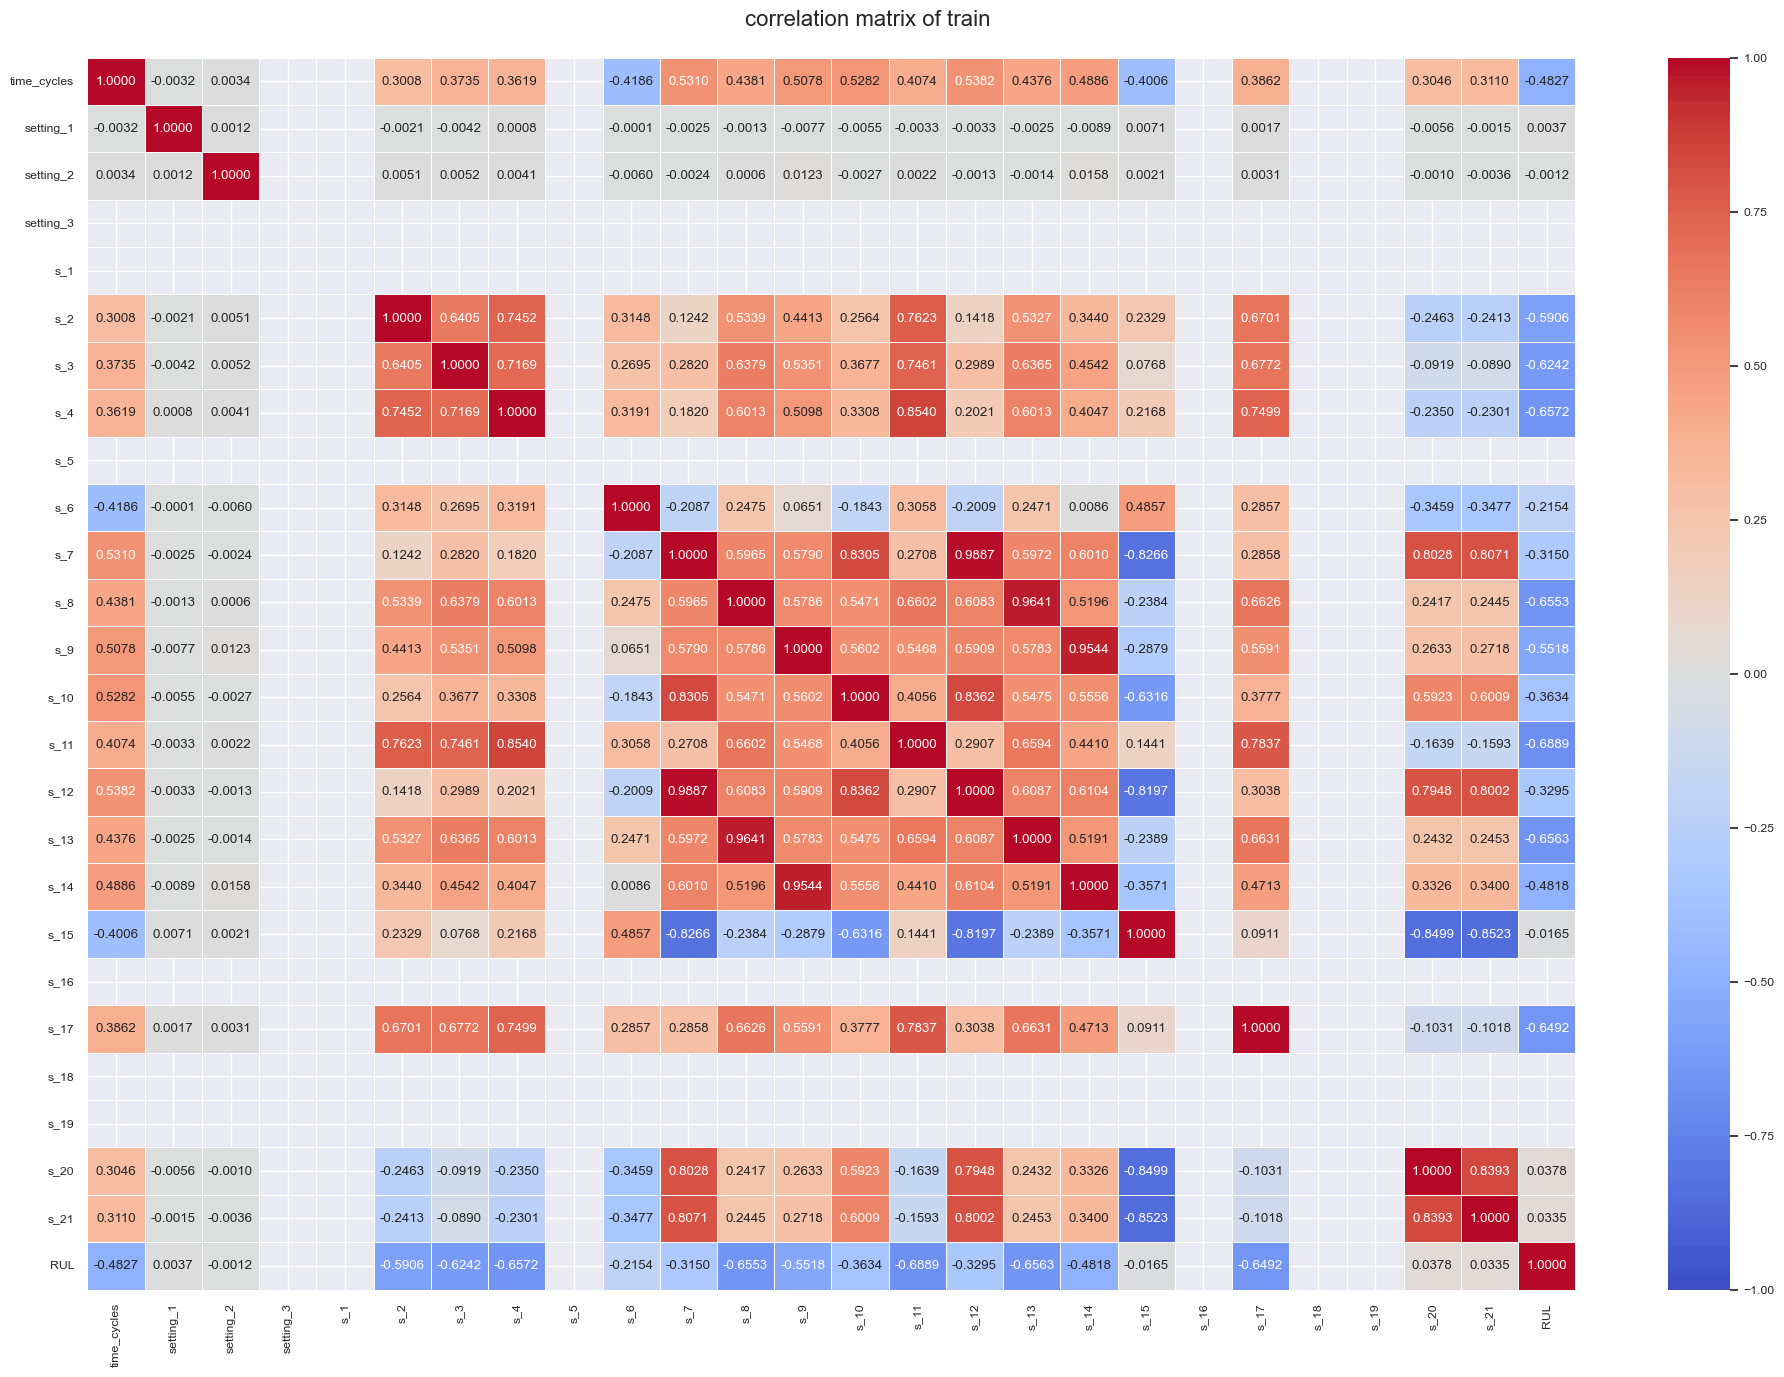

In [149]:
# calculate correlation
df_corr = data_train.drop(columns=["engine_id"]).corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(24,16))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("coolwarm", 200))

plt.figtext(.45, 0.9,'correlation matrix of train', fontsize=16, ha='center')
plt.xticks(rotation=90)
plt.show()

### Distribution

In [150]:
data_train[data_train['engine_id'] == 1]

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,1,255,0.0050,-0.0004,100.0,518.67,643.40,1599.87,1427.90,14.62,...,2388.22,8143.28,8.5179,0.03,394,2388,100.0,38.39,23.0716,4
255,1,256,0.0019,0.0001,100.0,518.67,643.84,1599.31,1423.73,14.62,...,2388.22,8151.14,8.5058,0.03,397,2388,100.0,38.46,23.0488,3
256,1,257,-0.0032,-0.0002,100.0,518.67,643.52,1601.37,1425.25,14.62,...,2388.26,8149.36,8.5308,0.03,398,2388,100.0,38.36,23.1058,2
257,1,258,-0.0005,0.0001,100.0,518.67,643.66,1606.80,1431.35,14.62,...,2388.21,8150.92,8.4947,0.03,396,2388,100.0,38.49,23.0658,1


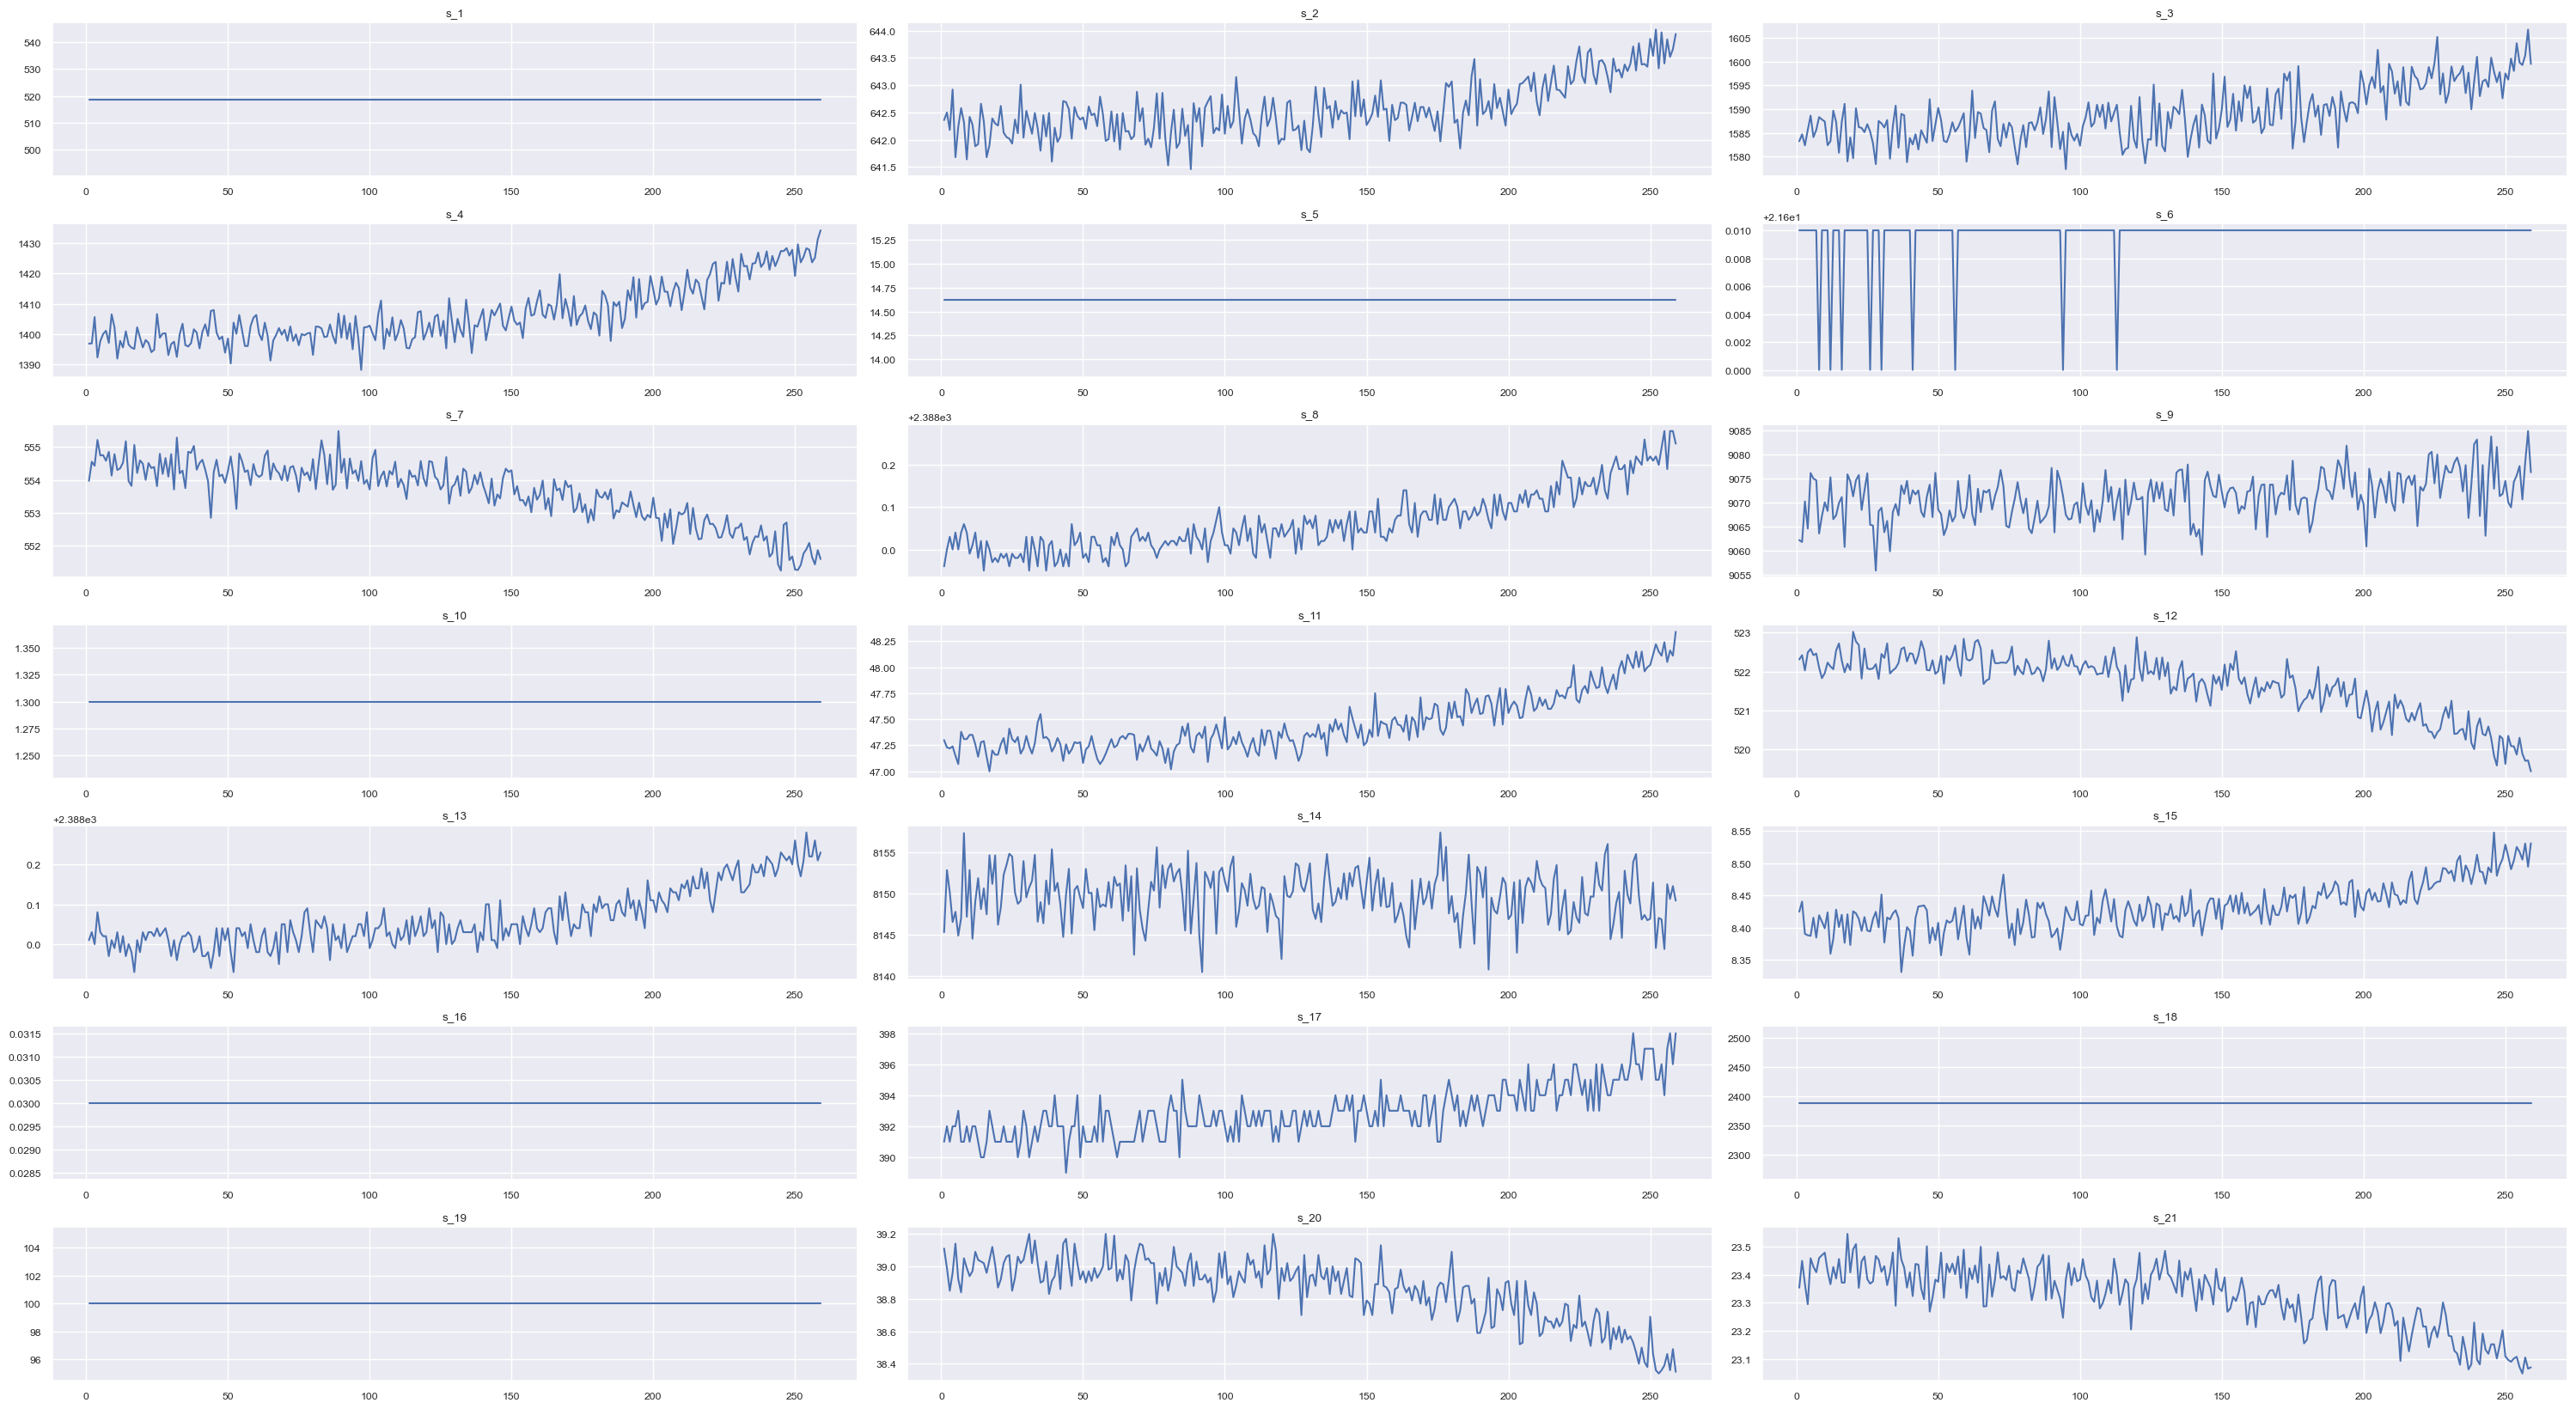

In [151]:
plt.figure(figsize=(30, 70))
for i in range(21):
    sensor = 's_' + str(i+1)
    plt.subplot(30, 3, i+1).set_title(sensor)
    ssdata = data_train[data_train['engine_id'] == 1]
    plt.plot(ssdata['time_cycles'], ssdata[sensor])
plt.tight_layout()

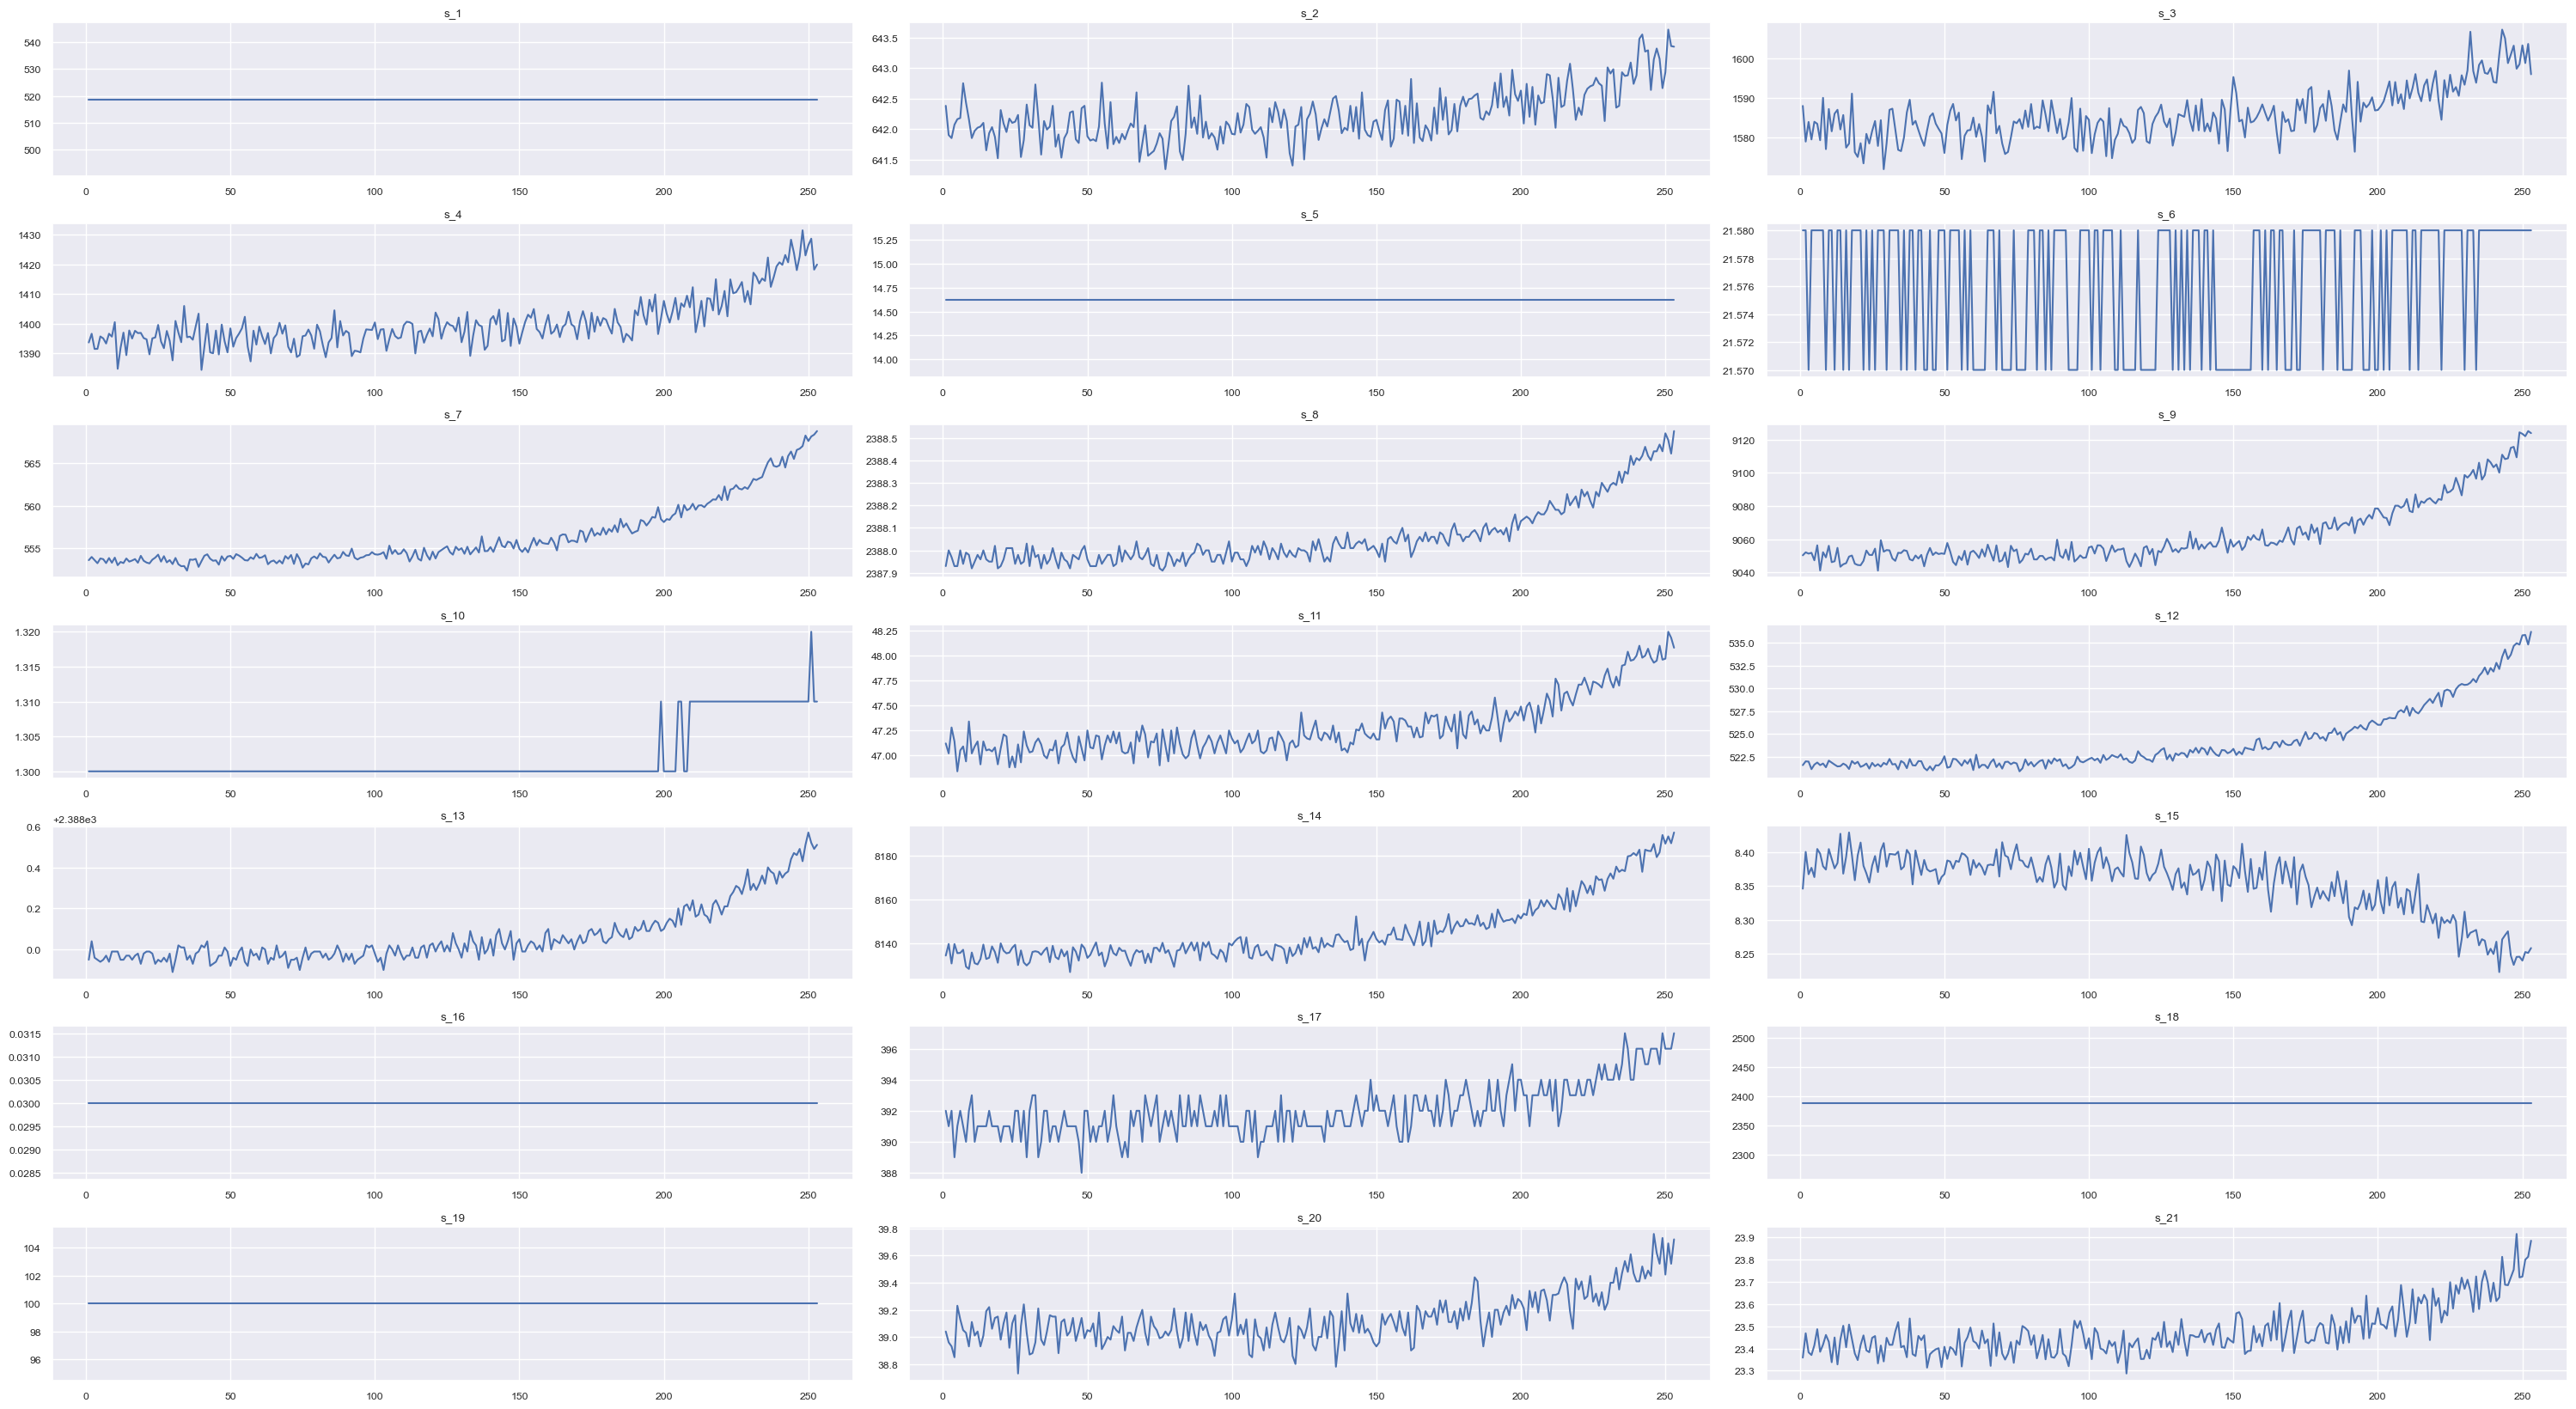

In [152]:
plt.figure(figsize=(30, 70))
for i in range(21):
    sensor = 's_' + str(i+1)
    plt.subplot(30, 3, i+1).set_title(sensor)
    ssdata = data_train[data_train['engine_id'] == 2]
    plt.plot(ssdata['time_cycles'], ssdata[sensor])
plt.tight_layout()

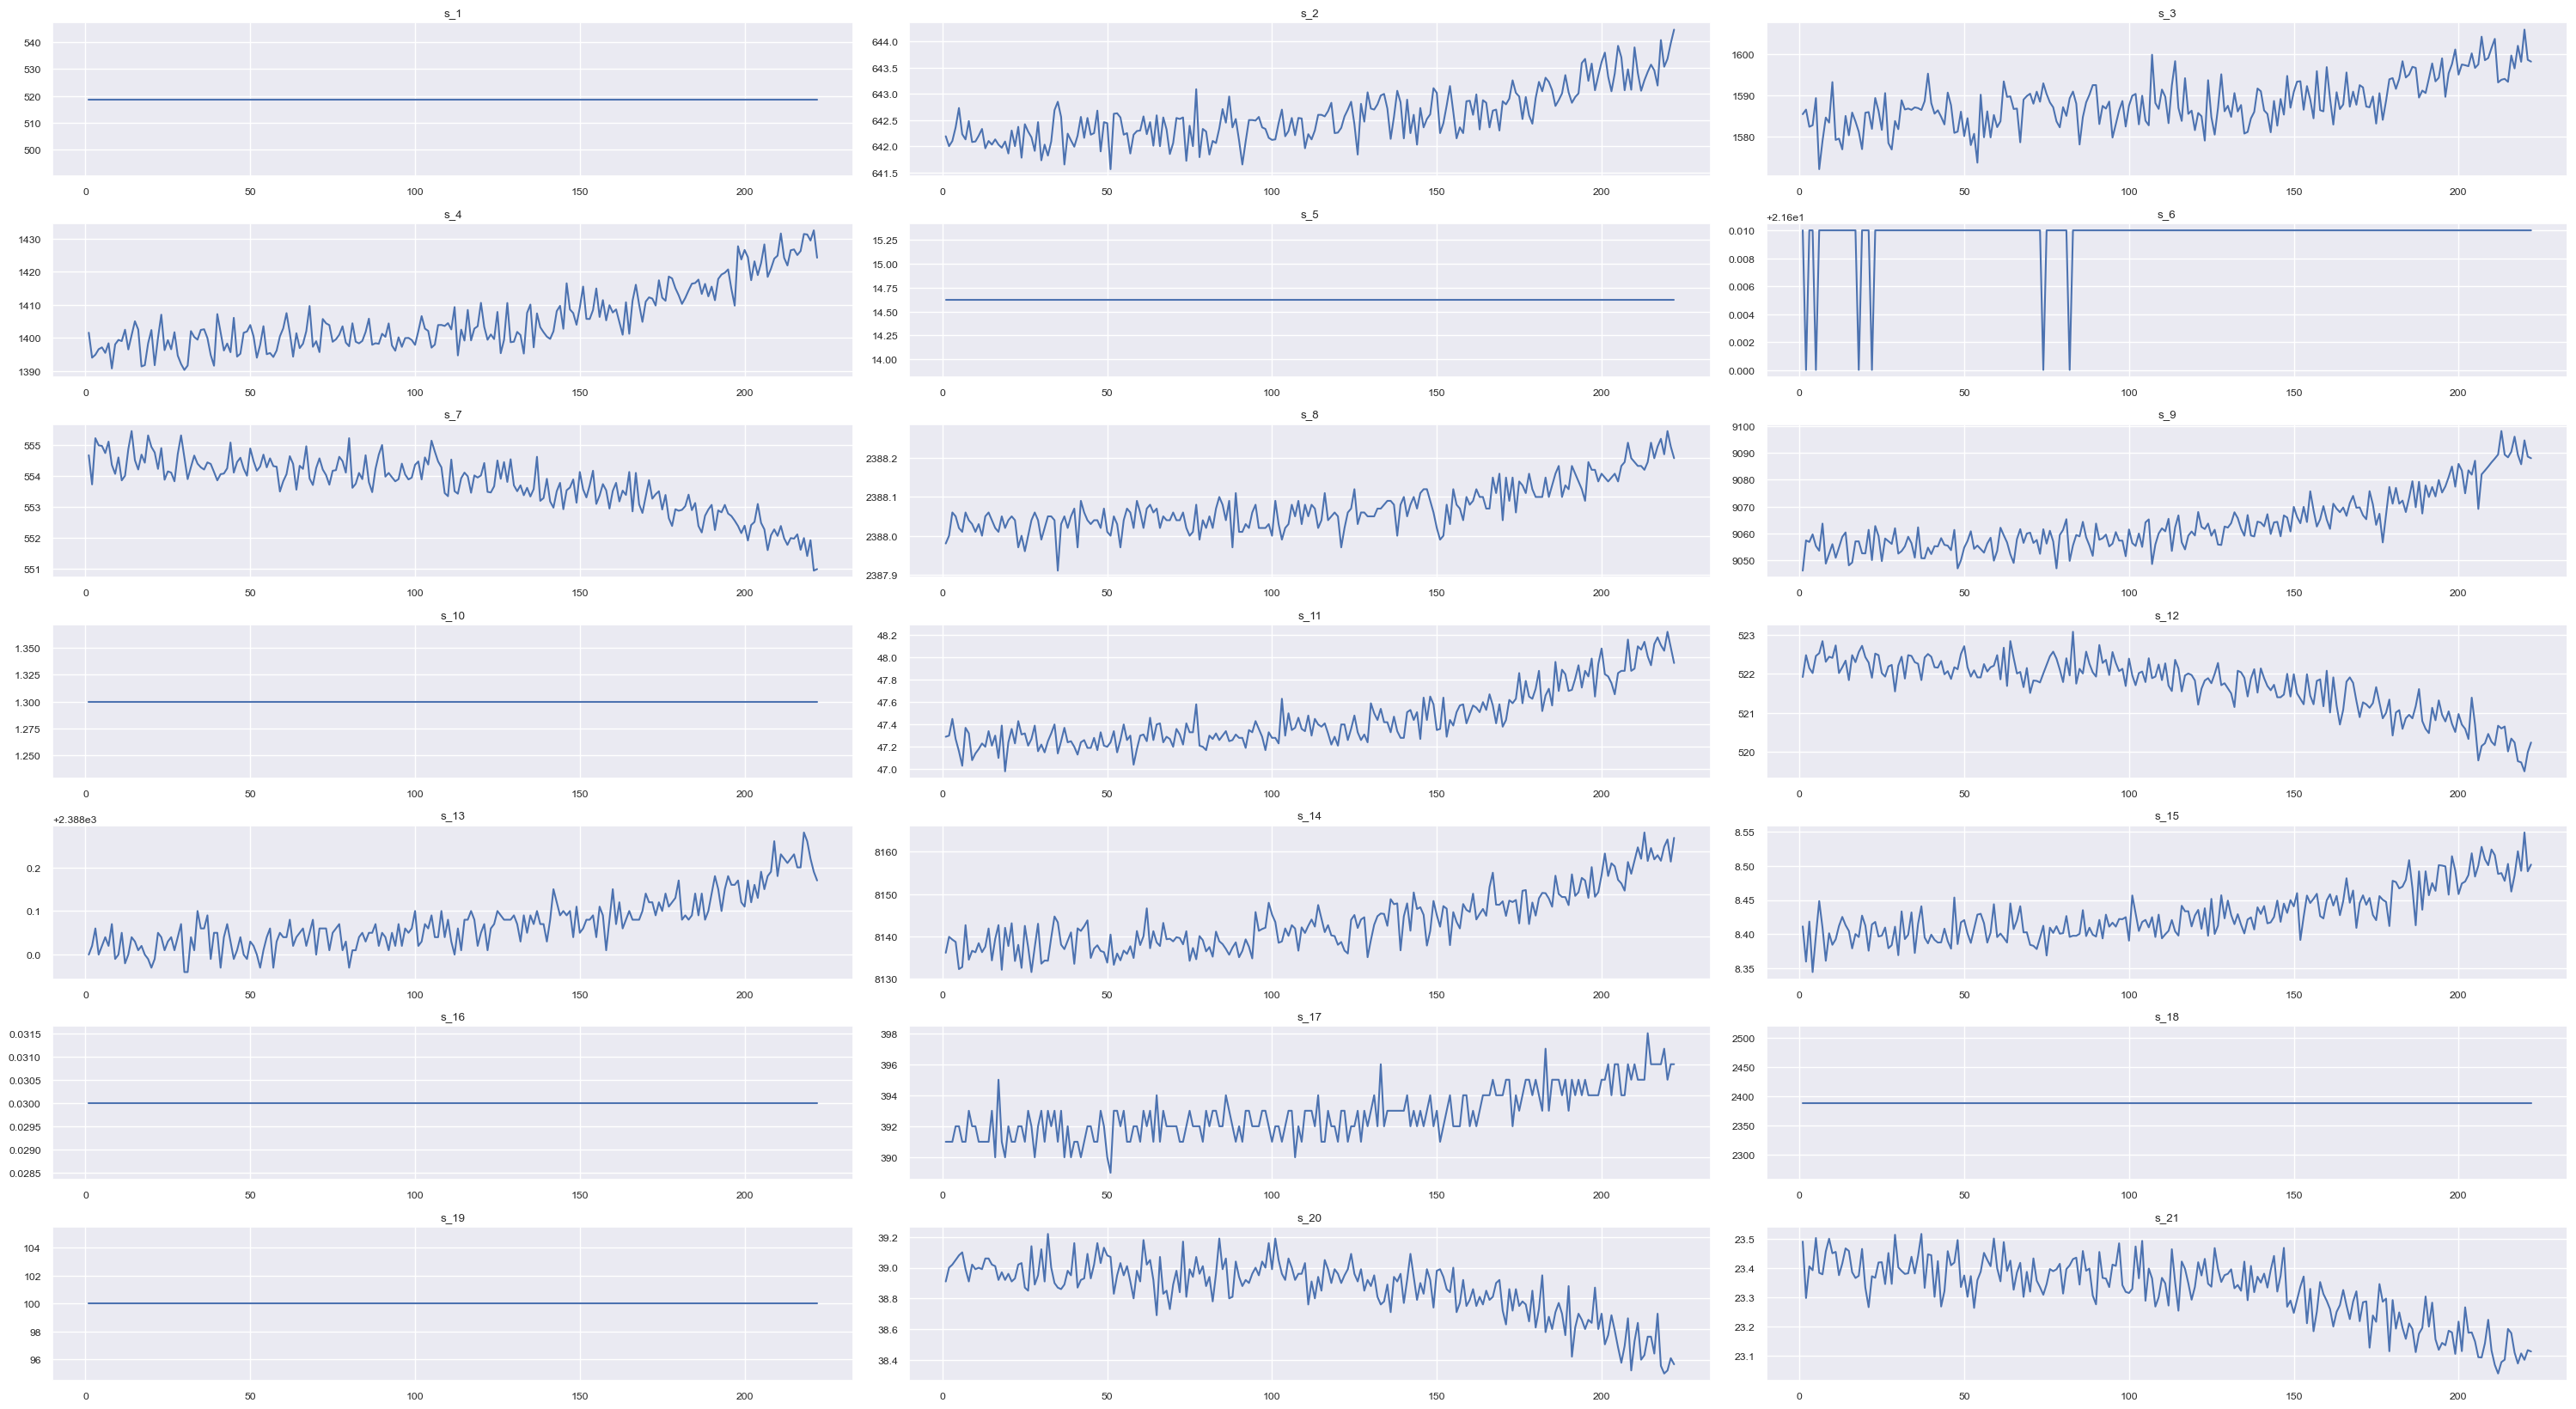

In [153]:
plt.figure(figsize=(30, 70))
for i in range(21):
    sensor = 's_' + str(i+1)
    plt.subplot(30, 3, i+1).set_title(sensor)
    ssdata = data_train[data_train['engine_id'] == 3]
    plt.plot(ssdata['time_cycles'], ssdata[sensor])
plt.tight_layout()

### Loại bỏ đi các cột ít tương quan

In [154]:
#drop columns which has std=0 because they don't carry info about the state of the unit
deleted_columns=["setting_1", "setting_2", "setting_3", "s_1", "s_5", "s_16", "s_18", "s_19"]

data_train.drop(columns=deleted_columns, inplace=True)
data_test.drop(columns=deleted_columns, inplace=True)

print(data_train.shape)
print(data_test.shape)

(24720, 19)
(16596, 19)


In [155]:
droped_columns = ["engine_id", "time_cycles"]

x_train = data_train.iloc[:, :-1]
x_test = data_test.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
y_test = data_test.iloc[:, -1]

x_train.drop(droped_columns, axis=1, inplace=True)
x_test.drop(droped_columns, axis=1, inplace=True)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_test, y_test = shuffle(x_test, y_test, random_state=0)

y_train_copy = np.array(y_train.reshape(-1, 1))
y_test_copy = np.array(y_test.reshape(-1, 1))

(24720, 16)
(16596, 16)
(24720,)
(16596,)


# Huấn luyện mô hình

### Sử dụng ANN (Artificial Neural Network)

In [156]:
ANN_model = Sequential()
ANN_model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))

ANN_model.add(Dense(64, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(128, activation='relu'))
ANN_model.add(Dense(256, activation='relu'))
ANN_model.add(Dropout(0.1))
ANN_model.add(Dense(64, activation='relu'))
ANN_model.add(Dense(1, activation='linear'))

ANN_model.compile(optimizer='Adam', loss='mean_absolute_error')
ANN_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 90.9037 - val_loss: 78.9026
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.6389 - val_loss: 77.3308
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.6361 - val_loss: 77.9938
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.4149 - val_loss: 78.4278
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 78.0820 - val_loss: 78.9107
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.9683 - val_loss: 77.2902
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.3915 - val_loss: 77.4970
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.8484 - val_loss: 79.0226
Epoch 9/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 76.9915 - val_loss: 77.7225
Epoch 10/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 77.8389 - val_loss: 77.4357


In [157]:
pred = ANN_model.predict(x_test)
print(y_test[50:70])
print(pred[50:70])

519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
[ 97  66  19  38  73 129  57  88 134 450  54   7  32  18 239  25  86 150
 191  60]
[[115.02733 ]
 [114.811066]
 [115.05297 ]
 [115.03646 ]
 [115.0539  ]
 [114.80365 ]
 [115.023895]
 [115.006   ]
 [114.734344]
 [115.00367 ]
 [115.08127 ]
 [115.06865 ]
 [115.03707 ]
 [115.03382 ]
 [114.95381 ]
 [114.99616 ]
 [114.850815]
 [115.05174 ]
 [115.1843  ]
 [115.049255]]


### Sử dụng LSTM (Long Short Term Memory)

In [178]:
max_len = 200
num_of_sensors = 16
input_shape = (max_len, num_of_sensors)

CNN_LSTM_model = Sequential()
CNN_LSTM_model.add(Convolution1D(input_shape=input_shape, filters=18, kernel_size=2, strides=1, padding='same', activation='relu'))
CNN_LSTM_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN_LSTM_model.add(Convolution1D(filters=36, kernel_size=2, strides=1, padding='same', activation='relu'))
CNN_LSTM_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN_LSTM_model.add(Convolution1D(filters=72, kernel_size=2, strides=1, padding='same', activation='relu'))
CNN_LSTM_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
CNN_LSTM_model.add(Dense(input_shape[0]*input_shape[1], activation='relu'))
CNN_LSTM_model.add(Dropout(0.1))
CNN_LSTM_model.add(LSTM(input_shape[1]*3, return_sequences=True))
CNN_LSTM_model.add(Dropout(0.15))
CNN_LSTM_model.add(LSTM(input_shape[1]*3))
CNN_LSTM_model.add(Dropout(0.2))
CNN_LSTM_model.add(Dense(50, activation='relu'))
CNN_LSTM_model.add(Dropout(0.2))
CNN_LSTM_model.add(Dense(1, activation='linear'))

CNN_LSTM_model.compile(optimizer='rmsprop', loss='mse')
CNN_LSTM_model.fit(x_train, y_train, epochs=10, batch_size=200)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1
'y' sizes: 24720
